# Глубинное обучение, ИИ ВШЭ

## Домашнее задание 2. Классификация при помощи CNN. 

### Общая информация

### Оценивание и штрафы

Максимально допустимая оценка за работу без бонусов — 10 баллов. Сдавать задание после указанного срока жесткого дедлайна нельзя.

Сдача работы после мягкого дедлайна штрафуется ступенчато, -1 балл в сутки. Один раз за модуль студентам предоставляется возможность использовать отсрочку и сдать в жесткий дедлайн без штрафа.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Использование генеративных моделей допустимо на следующих условиях:
- Количество кода, написанное генеративными моделями, не превышает 30%
- Указана модель, использованная для генерации, а также промпт
- В конце работы необходимо описать свой опыт использования генеративного ИИ для решения данного домашнего задания. Укажите как часто Вам приходилось исправлять код своими руками или просить модель что-то исправить. Было ли это быстрее, чем написать код самим? 

В случае невыполнения этих требований работа не оценивается и оценка за неё не превышает 0 баллов.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [8]:
# Для тру нормализации
# mean = [0.4914, 0.4822, 0.4465]
# std = [0.2470, 0.2435, 0.2616]
# Тут взяты значения как в одном из туториалов пайторча :)


def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [
            transforms.ToTensor(),
            # Переводим цвета пикселей в отрезок [-1, 1]
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform_train
    )
    testset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform_test
    )

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(
        np.arange(len(trainvalset)), test_size=0.3, shuffle=True, random_state=0
    )
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    val_loader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=False, num_workers=2
    )
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    return train_loader, val_loader, test_loader

In [11]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

Посмотрим на изображения:

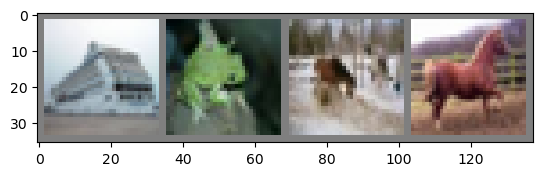

ship frog horse horse frog cat truck truck


In [13]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
print(*[classes[labels[i]] for i in range(8)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры, похожей на ResNet. Обратите внимание, это не ResNet 1 в 1.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [14]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn_1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bn_2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1)
        self.avgpool = nn.AvgPool2d(kernel_size=8)
        self.fc = nn.Linear(512, n_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn_1(out)
        out = F.relu(out)
        
        out = self.conv2(out)
        out = self.bn_2(out)

        out1 = self.conv3(x)
        
        out += out1
        out =  F.relu(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

In [15]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (avgpool): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [15]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [19]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [56]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            
            y_pred = model(data)
            loss = F.cross_entropy(y_pred, target)
            
            loss_log.append(loss.item())
            
            pred_classes = y_pred.argmax(dim=1)
            acc = (pred_classes == target).float().mean()
            acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        y_pred = model(data)
        loss = F.cross_entropy(y_pred, target)
        loss.backward()
        optimizer.step()       
        optimizer.zero_grad()
        
        loss_log.append(loss.item())
        
        pred_classes = y_pred.argmax(dim=1)
        acc = (pred_classes == target).float().mean()
        acc_log.append(acc.item())

    return loss_log, acc_log


def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [24]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

Epoch 0
 train loss: 1.455233200921437, train acc: 0.4829508358207438
 val loss: 1.205799281089864, val acc: 0.5730939718002969

Epoch 1
 train loss: 1.1453266779073195, train acc: 0.6007606425276623
 val loss: 1.1371711203392516, val acc: 0.6078457446808511

Epoch 2
 train loss: 1.035899308525448, train acc: 0.639580340882324
 val loss: 1.089921360827507, val acc: 0.6244015957446809

Epoch 3
 train loss: 0.9845947511017431, train acc: 0.6582128166934472
 val loss: 1.055056693198833, val acc: 0.6351728723404255

Epoch 4
 train loss: 0.9497658073139364, train acc: 0.6695816466751656
 val loss: 1.0087687852534841, val acc: 0.6550088654173182

Epoch 5
 train loss: 0.9287214408844873, train acc: 0.6782857796391796
 val loss: 0.9492705324862866, val acc: 0.6739140071767442

Epoch 6
 train loss: 0.8995059978155593, train acc: 0.6865655197957752
 val loss: 1.0354236336464577, val acc: 0.6480939718002968

Epoch 7
 train loss: 0.8830705838077029, train acc: 0.6935353552619543
 val loss: 0.97785

Посчитайте точность на тестовой выборке:

In [28]:
loss, accuracy = test(net, test_loader)
print(f"Точность на тесте: {accuracy:.4f}")

Точность на тесте: 0.6936


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

In [30]:
def plot_history(train_history, val_history, title):
    plt.figure()
    plt.title(title)
    val_steps =[i * len(train_history) // 20 for i in range(20)]
    plt.plot(train_history, label="train", zorder=1)
    plt.plot(val_steps, val_history, label="validation", marker='+')
    plt.xlabel("шаги")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

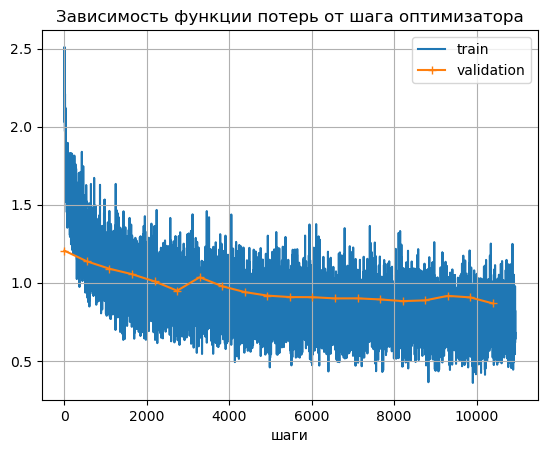

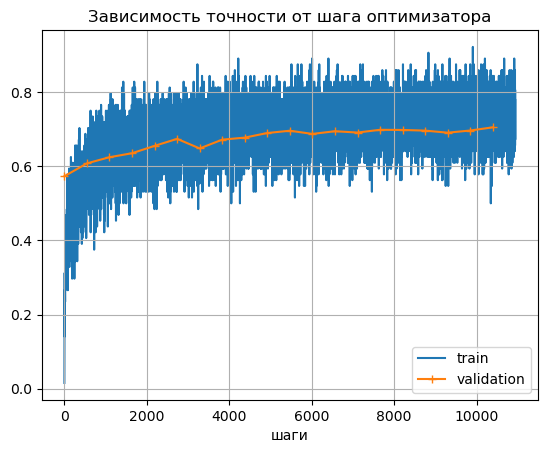

In [84]:
plot_history(train_loss_log, val_loss_log, "Зависимость функции потерь от шага оптимизатора")
plot_history(train_acc_log, val_acc_log, "Зависимость точности от шага оптимизатора")

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [86]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.4670813788661574, train acc: 0.4765318948128542
 val loss: 1.2804554021104853, val acc: 0.5486702127659574

Epoch 1
 train loss: 1.152219993976614, train acc: 0.5957291395398338
 val loss: 1.1362103452073766, val acc: 0.6048315603682335

Epoch 2
 train loss: 1.0524351389796032, train acc: 0.6333164665337236
 val loss: 1.1681448875589573, val acc: 0.5917331561129144

Epoch 3
 train loss: 0.9972092860141664, train acc: 0.6513898864088808
 val loss: 0.9958628068579004, val acc: 0.6524157801841167

Epoch 4
 train loss: 0.9552856567136985, train acc: 0.6665129603807843
 val loss: 1.0031082330866063, val acc: 0.6480939716734785

Epoch 5
 train loss: 0.9229104391944474, train acc: 0.6784449269828239
 val loss: 0.9625248358604755, val acc: 0.6682402483960416

Epoch 6
 train loss: 0.904915930529617, train acc: 0.6831907809761368
 val loss: 0.9522246647388377, val acc: 0.6767287234042553

Epoch 7
 train loss: 0.8868984520108434, train acc: 0.6898341603863174
 val loss: 0.9

Посчитайте точность на тестовой выборке:

In [88]:
loss, accuracy = test(net, test_loader)
print(f"Точность на тесте: {accuracy:.4f}")

Точность на тесте: 0.7175


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [90]:
lr = 0.001
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.8587564851073939, train acc: 0.3467778793418647
 val loss: 1.6385292814133015, val acc: 0.4318484042553192

Epoch 1
 train loss: 1.572607450554968, train acc: 0.44757932882204354
 val loss: 1.488346047097064, val acc: 0.47794769507773377

Epoch 2
 train loss: 1.4449344352568743, train acc: 0.49215281412849915
 val loss: 1.408051945808086, val acc: 0.5046320922831271

Epoch 3
 train loss: 1.36081509550921, train acc: 0.5224601724465978
 val loss: 1.3143645093796101, val acc: 0.5402039007937655

Epoch 4
 train loss: 1.299623813010221, train acc: 0.5451978324100348
 val loss: 1.2576164692006213, val acc: 0.5645833333756062

Epoch 5
 train loss: 1.2457580520640343, train acc: 0.5637323714697383
 val loss: 1.2152322502846413, val acc: 0.5783687944107867

Epoch 6
 train loss: 1.2047270691155079, train acc: 0.5814140442302501
 val loss: 1.2026736089523802, val acc: 0.5805629433469569

Epoch 7
 train loss: 1.1603246946875312, train acc: 0.5962433077299617
 val loss: 1.16

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

Представленные способы можно объединить в группы:

 - **Шаговые**: StepLR, MultiStepLR, ExponentialLR, PolynomialLR, CosineAnnealingLR. Они уменьшают шаг по заранее заданным правилам, обычно через несколько эпох.
 
 - **Циклические**: CyclicLR, OneCycleLR изменяют learning rate по циклу или по графику, например как CosineAnnealingWarmRestarts

 - **Зависимые от метрики**: ReduceLROnPlateau изменяет шаг, отслеживая метрику.

 - **Дополнительная настройка**: LambdaLR, ChainedScheduler, SequentialLR позволяют задать функции или последовательность планировщиков с другими типами способов, которые будут вызываться последовательно в процессе оптимизации.


Попробуем использовать ExponentialLR, CyclicLR и ReduceLROnPlateau

**ExponentialLR**

- Уменьшает скорость обучения для каждой группы параметров на величину gamma в каждую эпоху.
- lr_epoch = gamma * lr_(epoch-1)
- Плавно уменьшает learning rate. Однако он не адаптивен и следую вручную подбирать gamma

In [103]:
lr = 0.1
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)
test_loss, test_acc = test(net, test_loader)
print(f"Точность c ExponentialLR: {test_acc:.4f}\n")

Epoch 0
 train loss: 1.4829384201841338, train acc: 0.4676237268683244
 val loss: 1.2623736891340702, val acc: 0.5565824468085107

Epoch 1
 train loss: 1.1576568314318683, train acc: 0.5930889266282593
 val loss: 1.148706685989461, val acc: 0.5952570922831272

Epoch 2
 train loss: 1.0359442587090584, train acc: 0.6384744711724234
 val loss: 1.0851842347611773, val acc: 0.6251773050490846

Epoch 3
 train loss: 0.9816170313022691, train acc: 0.6576088731206096
 val loss: 1.0384690378574615, val acc: 0.6394281914893617

Epoch 4
 train loss: 0.9356469409557322, train acc: 0.6744540024283163
 val loss: 1.0206657640477443, val acc: 0.6419769505237011

Epoch 5
 train loss: 0.904651449084064, train acc: 0.6873530948183872
 val loss: 0.9384845495223999, val acc: 0.6744237590343394

Epoch 6
 train loss: 0.8763025912985724, train acc: 0.6969386589810442
 val loss: 0.9444206831303049, val acc: 0.6745789007937655

Epoch 7
 train loss: 0.8557320859902956, train acc: 0.7025047336897423
 val loss: 0.9

**CyclicLR**

- Циклические изменяет learning rate с возможностью разных видов цикла (triangular, triangular2, exp_range) triangular: линейно возрастает до максимального lr и затем падает. triangular2: также линейно возрастает, но каждый следующий цикл в 2 раза ниже. В exp_range максимальное значе6ние lr экспоненциально уменьшается с каждым циклом.
- Помогает выйти из локальных минимумов
- Имеет слишком много параметров для настройки

In [106]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-2, step_size_up=2000)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)
test_loss, test_acc = test(net, test_loader)
print(f"Точность c CyclicLR: {test_acc:.4f}\n")

Epoch 0
 train loss: 2.359063073529622, train acc: 0.08982436668120965
 val loss: 2.317879308538234, val acc: 0.11214539009205839

Epoch 1
 train loss: 2.274855221865164, train acc: 0.1439099634369287
 val loss: 2.2396135340345666, val acc: 0.17065602838993071

Epoch 2
 train loss: 2.203089203215604, train acc: 0.1947350809844364
 val loss: 2.1677454978861705, val acc: 0.21597960997135082

Epoch 3
 train loss: 2.135601633427566, train acc: 0.23864341212582982
 val loss: 2.099723251829756, val acc: 0.25638297872340426

Epoch 4
 train loss: 2.075433107355177, train acc: 0.2734313789734675
 val loss: 2.041745524710797, val acc: 0.2899157801841168

Epoch 5
 train loss: 2.023088891719769, train acc: 0.29810737141525506
 val loss: 1.991611235699755, val acc: 0.31316489361702127

Epoch 6
 train loss: 1.9767106710447908, train acc: 0.3167602507571198
 val loss: 1.9482831660737383, val acc: 0.33091755319148936

Epoch 7
 train loss: 1.9336820819042282, train acc: 0.3370127644682715
 val loss: 1.

**ReduceLROnPlateau**

- Работает адаптивно: когда метрика перестаетулучшаться, уменьшает lr в factor раз
- Параметр patience указывает, сколько эпох ждать улучшения
- Полезен, когда заранее непонятно, когда должно меняться lr

In [35]:
lr = 0.1
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)
test_loss, test_acc = test(net, test_loader)
print(f"Точность c ReduceLROnPlateau: {test_acc:.4f}\n")

Epoch 0
 train loss: 1.47686104495521, train acc: 0.4741120397281821
 val loss: 1.3542470850843065, val acc: 0.5244459220703612

Epoch 1
 train loss: 1.1552685200623227, train acc: 0.5945212522851919
 val loss: 1.1612578143464758, val acc: 0.5960106382978724

Epoch 2
 train loss: 1.0556240598288054, train acc: 0.6308231588037619
 val loss: 1.010897403067731, val acc: 0.6439273050490846

Epoch 3
 train loss: 0.9945346349663011, train acc: 0.6559521089524194
 val loss: 0.9812973273561356, val acc: 0.6642952127659575

Epoch 4
 train loss: 0.9585031737357215, train acc: 0.6669006268110746
 val loss: 0.9763453473436071, val acc: 0.6579565603682336

Epoch 5
 train loss: 0.9337022778538943, train acc: 0.6749722513027994
 val loss: 1.002427046349708, val acc: 0.6556959220703612

Epoch 6
 train loss: 0.9071234919035457, train acc: 0.6849128363119401
 val loss: 0.9816589779042183, val acc: 0.6591533688788719

Epoch 7
 train loss: 0.8830452803283985, train acc: 0.6918010577641196
 val loss: 0.990

- Точность c ExponentialLR: 0.7073
- Точность c CyclicLR: 0.4542
- Точность c ReduceLROnPlateau: 0.6907

ExponentialLR и ReduceLROnPlateau показали примерно одинаковую точность. ExponentialLR сам по себе хорошо работает, т.к. плавно снижает скорость обучения. ReduceLROnPlateau снижает lr только, если метрика перестает улучшаться. CyclicLR показал самую низкую точность, т.к. lr начинает скакать при неудачно подобранных максимального и минимального значений.

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

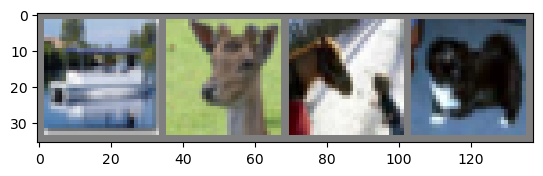

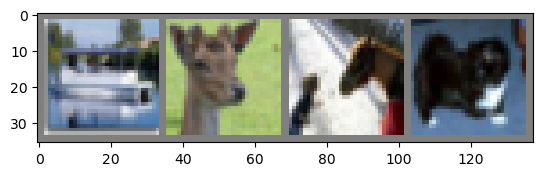

In [28]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [30]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.4826644181769335, train acc: 0.4710678376488973
 val loss: 1.289723694831767, val acc: 0.5388519503968827

Epoch 1
 train loss: 1.1780077038125103, train acc: 0.5889388548390739
 val loss: 1.118623952662691, val acc: 0.6102615249917862

Epoch 2
 train loss: 1.0566626423237746, train acc: 0.6321861126087266
 val loss: 1.0407722148489444, val acc: 0.6401817377577437

Epoch 3
 train loss: 0.9988560702726653, train acc: 0.6546258815245829
 val loss: 0.9675577488351376, val acc: 0.6648936170212766

Epoch 4
 train loss: 0.9548345269189238, train acc: 0.6683043875685558
 val loss: 0.9767148203038155, val acc: 0.6570478723404255

Epoch 5
 train loss: 0.9226366430793428, train acc: 0.6785918321644366
 val loss: 0.9240001967612733, val acc: 0.6734929079705096

Epoch 6
 train loss: 0.9044546096481832, train acc: 0.6861778532565185
 val loss: 0.927173768966756, val acc: 0.67788120584285

Epoch 7
 train loss: 0.8875040769359094, train acc: 0.6924090820213122
 val loss: 0.8722

Посчитайте точность на тестовой выборке:

In [33]:
test_loss, test_acc = test(net, test_loader)
print(f"Точность на тесте RandomHorizontalFlip: {test_acc:.4f}\n")

Точность на тесте RandomHorizontalFlip: 0.7311



**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

Попробуем слуедующие трансформации и их объединение:

- **RandomAffine**: случайная аффинная трансформация. Такие аугментации помогают модели стать устойчивее к незначительным искажениям

- **GaussianBlur**: гауссово размытие изображения. Может помочь игнорировать незначительные детали и соседотачиваться на крупных объектах

- **ColorJitter**: случайное изменение яркости, контрастности, оттенка изображения. Такие аугментации помогают модели стать устойчивее изменениям освещения или цветов

In [36]:
# RandomAffine
transform_rotation = transforms.Compose(
    [
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.6, 1.2)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform_rotation
)
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)
test_loss, test_acc = test(net, test_loader)
print(f"Точность на тесте RandomAffine: {test_acc:.4f}\n")

Epoch 0
 train loss: 1.6719842547690411, train acc: 0.39486076659650643
 val loss: 1.4937079576735801, val acc: 0.4610150710065314

Epoch 1
 train loss: 1.4281203398103035, train acc: 0.49005941499085925
 val loss: 1.3474658509518238, val acc: 0.5166888297872341

Epoch 2
 train loss: 1.306234922225994, train acc: 0.532592550274223
 val loss: 1.3078595866548255, val acc: 0.5449689716734785

Epoch 3
 train loss: 1.242895088422451, train acc: 0.5601127906081009
 val loss: 1.2009874265244667, val acc: 0.5808953901554675

Epoch 4
 train loss: 1.1975031668350944, train acc: 0.5757051450242944
 val loss: 1.2505308564673079, val acc: 0.5687943263256804

Epoch 5
 train loss: 1.160178258824392, train acc: 0.5918483938987774
 val loss: 1.171917132367479, val acc: 0.5888962765957447

Epoch 6
 train loss: 1.1487599815049598, train acc: 0.5952843432016739
 val loss: 1.2046303868293762, val acc: 0.5764627659574468

Epoch 7
 train loss: 1.1268458710728007, train acc: 0.5995731588037619
 val loss: 1.15

In [64]:
# GaussianBlur
transform_color = transforms.Compose(
    [
        transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)), 
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)


train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform_color
)
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)
test_loss, test_acc = test(net, test_loader)
print(f"Точность на тесте GaussianBlur: {test_acc:.4f}\n")

Epoch 0
 train loss: 1.5827289287961162, train acc: 0.43479857671413386
 val loss: 1.4578573876238883, val acc: 0.4783909574468085

Epoch 1
 train loss: 1.338874685481, train acc: 0.5265408723838151
 val loss: 1.2543102388686322, val acc: 0.5543218085106383

Epoch 2
 train loss: 1.242949113658403, train acc: 0.5631977997488687
 val loss: 1.1967601773586678, val acc: 0.5832003547790202

Epoch 3
 train loss: 1.181557302610094, train acc: 0.5849642531309529
 val loss: 1.1582872388210703, val acc: 0.5920656029214251

Epoch 4
 train loss: 1.143991782416809, train acc: 0.5984509663564413
 val loss: 1.1292039158496452, val acc: 0.604720744680851

Epoch 5
 train loss: 1.1148110150855028, train acc: 0.6065225908481661
 val loss: 1.1209982496626834, val acc: 0.6031028369639783

Epoch 6
 train loss: 1.0970574324266131, train acc: 0.6150634957841807
 val loss: 1.113798750461416, val acc: 0.609219858240574

Epoch 7
 train loss: 1.0856097589027294, train acc: 0.6199032058445584
 val loss: 1.12266815

In [60]:
# ColorJitter
transform_color = transforms.Compose(
    [
        transforms.ColorJitter(
            brightness=0.2, contrast=0.2, saturation=0.2
        ), 
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)


train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform_color
)
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)
test_loss, test_acc = test(net, test_loader)
print(f"Точность на тесте ColorJitter: {test_acc:.4f}\n")

Epoch 0
 train loss: 1.5057142441189921, train acc: 0.4647631562388139
 val loss: 1.306890105947535, val acc: 0.5327570922831272

Epoch 1
 train loss: 1.1952194646681902, train acc: 0.5826219313759254
 val loss: 1.1188296703582115, val acc: 0.6095523050490846

Epoch 2
 train loss: 1.0787306515128783, train acc: 0.6259630452126428
 val loss: 1.062225900812352, val acc: 0.6388297872340426

Epoch 3
 train loss: 1.0057285483620066, train acc: 0.6518183599006542
 val loss: 0.9973848870460024, val acc: 0.6569592199427017

Epoch 4
 train loss: 0.9700926908409355, train acc: 0.6638482632541134
 val loss: 1.0048159571404154, val acc: 0.6507535461415636

Epoch 5
 train loss: 0.9386399253194904, train acc: 0.6738623009085437
 val loss: 1.0187125145120823, val acc: 0.6456560284533399

Epoch 6
 train loss: 0.9192336298647921, train acc: 0.6815340168079467
 val loss: 0.9455681359514277, val acc: 0.6723404255319149

Epoch 7
 train loss: 0.9087026204226004, train acc: 0.6838804192473291
 val loss: 0.9

In [61]:
# Комбинация всех 
transform_combined = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
        transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)


train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform_combined
)
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)
test_loss, test_acc = test(net, test_loader)
print(f"Точность на тесте с комбинацией аугментаций {test_acc:.4f}\n")

Epoch 0
 train loss: 1.759041481087805, train acc: 0.3647860081583752
 val loss: 1.6338761689815116, val acc: 0.4101285461415636

Epoch 1
 train loss: 1.5856675175469799, train acc: 0.42898357927908193
 val loss: 1.579508617076468, val acc: 0.43277925531914896

Epoch 2
 train loss: 1.5159266572547787, train acc: 0.4573770893339265
 val loss: 1.4955725867697534, val acc: 0.46079343975858483

Epoch 3
 train loss: 1.4714418364181379, train acc: 0.47354482242350604
 val loss: 1.4494809810151446, val acc: 0.49375

Epoch 4
 train loss: 1.4287723859659716, train acc: 0.48848426483666874
 val loss: 1.4147100342080947, val acc: 0.4984485816448293

Epoch 5
 train loss: 1.393878273597801, train acc: 0.5076594737918547
 val loss: 1.4431832584928959, val acc: 0.48818705677986146

Epoch 6
 train loss: 1.372167278033506, train acc: 0.5123196331412962
 val loss: 1.3619898567808435, val acc: 0.5086214539852548

Epoch 7
 train loss: 1.3593336531187543, train acc: 0.51433141815597
 val loss: 1.3547810029

- Точность на тесте RandomAffine: 0.6988

- Точность на тесте GaussianBlur: 0.6737

- Точность на тесте ColorJitter: 0.7178

- Точность на тесте  с комбинацией аугментаций 0.6397

- Точность бейзлана на тесте: 0.6936

Каждая из одиночных аугментаций показала улучшение по сравнению с базовым результатом. Наилучший эффект продемонстрировала аугментация ColorJitter (72%). Однако комбинация всех аугментаций дала худший результат. Возможно, увеличение количества эпох или выбор только двух аугментаций мог бы привести к лучшему результату.

## Бонус. Логирование в wandb (1 балл)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

Если вас смущает, что WandB грозится забанить вас, то можете разобраться с любым его аналогом и приложить ссылку на аналог.

In [48]:
import wandb

wandb.init(project="hse-dl", entity="ees-elena-hse")

def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            
            y_pred = model(data)
            loss = F.cross_entropy(y_pred, target)
            
            loss_log.append(loss.item())
            
            pred_classes = y_pred.argmax(dim=1)
            acc = (pred_classes == target).float().mean()
            acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        y_pred = model(data)
        loss = F.cross_entropy(y_pred, target)
        loss.backward()
        optimizer.step()       
        optimizer.zero_grad()
        
        loss_log.append(loss.item())
        
        pred_classes = y_pred.argmax(dim=1)
        acc = (pred_classes == target).float().mean()
        acc_log.append(acc.item())
        
    return loss_log, acc_log



def train(model, optimizer, num_epochs, train_loader, val_loader, scheduler=None):
    all_train_loss_values, all_train_accuracy_values = [], []
    all_val_loss_values, all_val_accuracy_values = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_epoch(model, optimizer, train_loader)
        val_loss, val_accuracy = test(model, val_loader)

        all_train_loss_values.extend(train_loss)
        all_train_accuracy_values.extend(train_accuracy)

        all_val_loss_values.append(val_loss)
        all_val_accuracy_values.append(val_accuracy)

        wandb.log({
            "train_loss": np.mean(train_loss),
            "train_accuracy": np.mean(train_accuracy),
            "val_loss": val_loss,
            "val_accuracy": val_accuracy,
            "epoch": epoch
        })

        print(f"Epoch {epoch}")
        print(f" loss(train): {np.mean(train_loss)}, acc(train): {np.mean(train_accuracy)}")
        print(f" loss(val): {val_loss}, acc(val): {val_accuracy}\n")

        if scheduler is not None:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

    return all_train_loss_values, all_train_accuracy_values, all_val_loss_values, all_val_accuracy_values

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)

train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)


wandb.finish()

Epoch 0
 loss(train): 1.483325601277883, acc(train): 0.471431019864091
 loss(val): 1.3162102039824142, acc(val): 0.5289450355032657

Epoch 1
 loss(train): 1.1857722791718825, acc(train): 0.5818629211437986
 loss(val): 1.133833110586126, acc(val): 0.6099734042553191

Epoch 2
 loss(train): 1.0638862912572062, acc(train): 0.6309782254630513
 loss(val): 1.074830733207946, acc(val): 0.627127659574468

Epoch 3
 loss(train): 1.008647584065223, acc(train): 0.6498555433161733
 loss(val): 1.0141639501490491, acc(val): 0.6405363476022761

Epoch 4
 loss(train): 0.9696922283721798, acc(train): 0.6649296487489174
 loss(val): 0.9287987348881174, acc(val): 0.6817597518575952

Epoch 5
 loss(train): 0.9331607766299622, acc(train): 0.6770085205325697
 loss(val): 1.0071152451190544, acc(val): 0.6492021276595744

Epoch 6
 loss(train): 0.9083111370067491, acc(train): 0.6827051776854604
 loss(val): 0.9460663605243602, acc(val): 0.6722739361702128

Epoch 7
 loss(train): 0.8886368124315028, acc(train): 0.69231

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇▇██████
train_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▄▅▅▇▅▆▆▇▇▇▇▇▇▇▇█▇██
val_loss,█▅▅▄▂▄▃▃▂▂▂▂▂▂▂▂▁▂▁▁
epoch,19
train_accuracy,0.74217
train_loss,0.7471
val_accuracy,0.71678
val_loss,0.83229


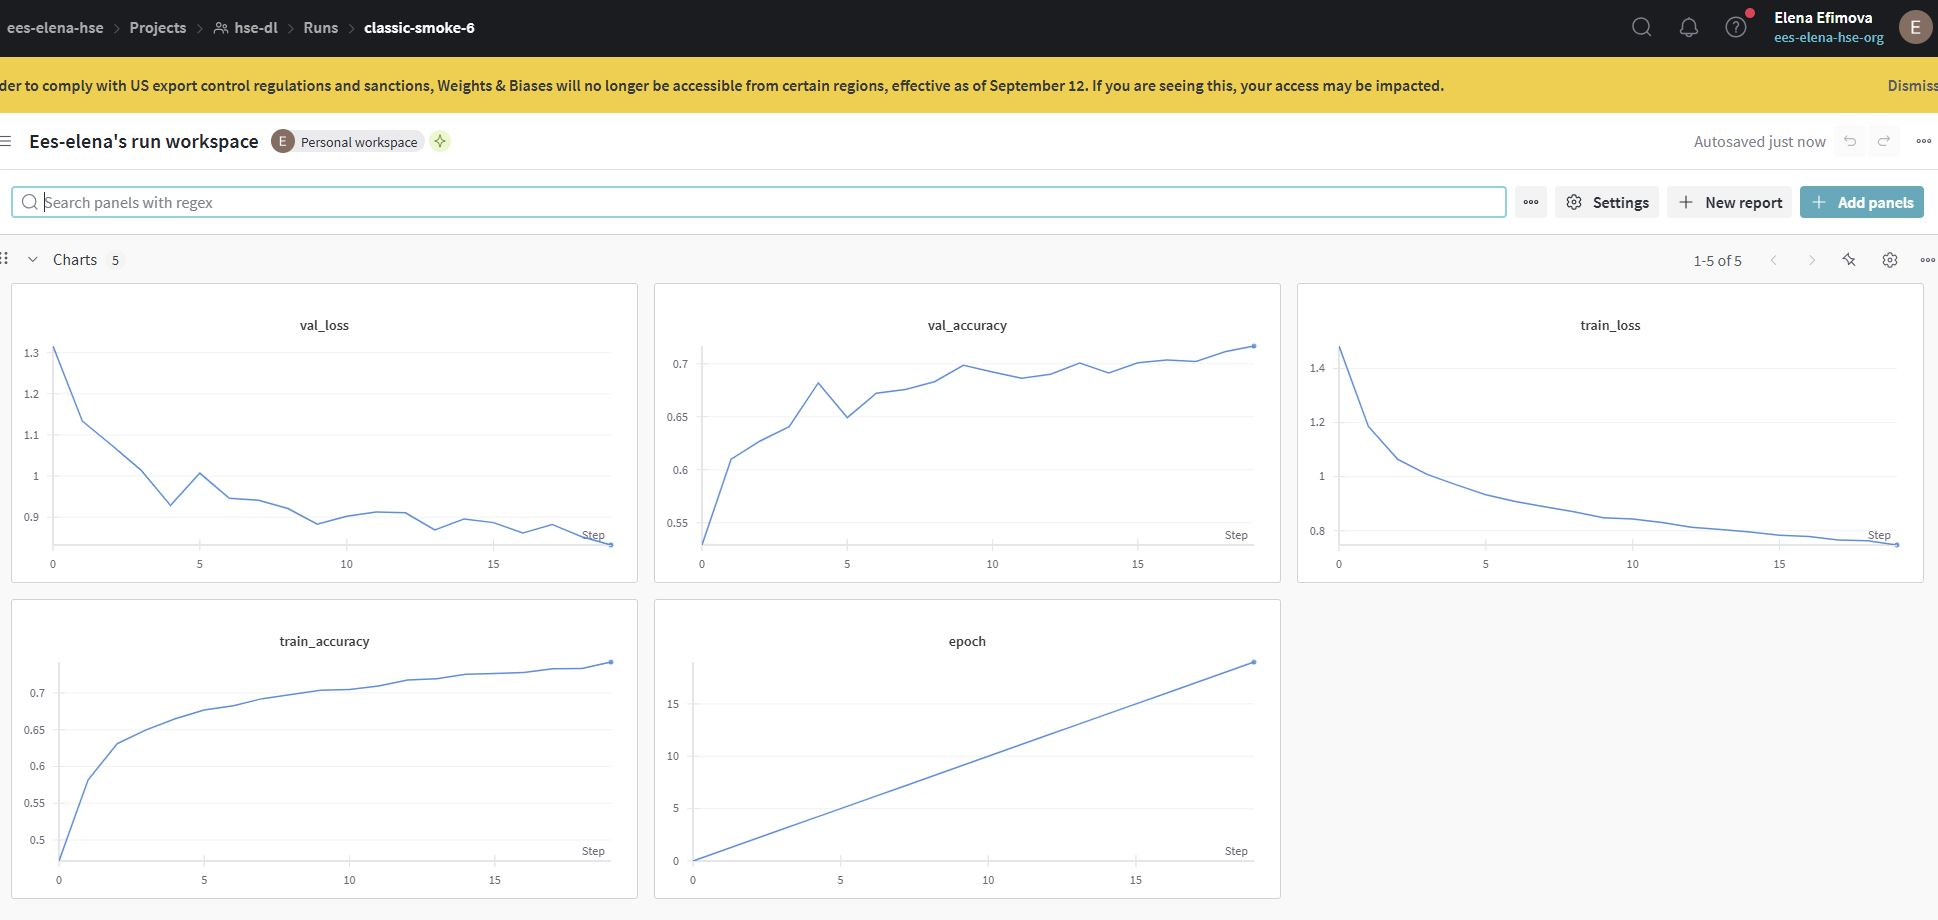

In [52]:
from IPython.display import Image

Image(filename='C:\\Users\\Администратор\\Desktop\\Снимок.JPG')